Here, we aim to demonstrate the hypernomy in the cognitive control literature.

In [ ]:
# imports and load the topic weights
# keep only popular constructs

%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from python.cogtext.plotting.rose_plot import rose_plot

# load the data
# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)


n_popular_labels = 50

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

pubmed = pubmed.query('pmid.notna() and abstract.notna()')
pubmed = pubmed.query('label in @popular_labels')

In [51]:
# assign documents to scientific communities

comm_cognit = pubmed.query('journal_title.str.contains("cogn",case=False)')
comm_neuros = pubmed.query('journal_title.str.contains("neur",case=False)')
comm_psycho = pubmed.query('journal_title.str.contains("psych",case=False)')
comm_social = pubmed.query('journal_title.str.contains("social",case=False)')

pubmed.loc[comm_cognit.index, 'scientific_community'] = 'cognitive'
pubmed.loc[comm_neuros.index, 'scientific_community'] = 'neuroscience'
pubmed.loc[comm_psycho.index, 'scientific_community'] = 'psychology'
pubmed.loc[comm_social.index, 'scientific_community'] = 'social'

# discard the rest
pubmed.dropna(subset=['scientific_community'], inplace=True)

print(f'Analyzing {len(pubmed)} documents...')

Analyzing 154990 documents...


In [52]:
# label embeddings (max-pooling)

def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]

def create_label_embeddings(df):
  label_embeddings = \
    df.groupby('label')['weights'].apply(lambda x: np.max(np.stack(x.values), axis=0))

  label_embeddings = pd.DataFrame(np.stack(label_embeddings), index=label_embeddings.index)
  label_embeddings['category'] = label_embeddings.index.to_series().apply(find_category_by_label)
  label_embeddings.set_index(['category'], append=True, inplace=True)

  return label_embeddings

def create_task_construct_matrix(df, metric='kl', normalize=False):  
  embeddings = create_label_embeddings(df)
  sim_df = get_similarity_matrix(
    embeddings,
    metric=metric,
    pivot_by_category=True)
  sim_df.columns.name = 'task'
  sim_df.index.name = 'construct'

  if normalize:
    sim_df = sim_df.div(sim_df.sum(axis=1), axis=0)

  return sim_df


def plot_hypernomy(label, df):
  comm_embeddings = df.query('construct == @label').stack().reset_index()
  comm_embeddings.rename(columns={0:'weight'}, inplace=True)

  _, ax = plt.subplots(figsize=(35,6))
  sns.set('poster')
  sns.barplot(hue='scientific_community', y='weight', x='task', data=comm_embeddings)

  plt.xticks(rotation=90, ha='center')
  # plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)
  plt.suptitle(f'"{label}" hypernomy across scientific communities', y= 1.05)
  plt.show()

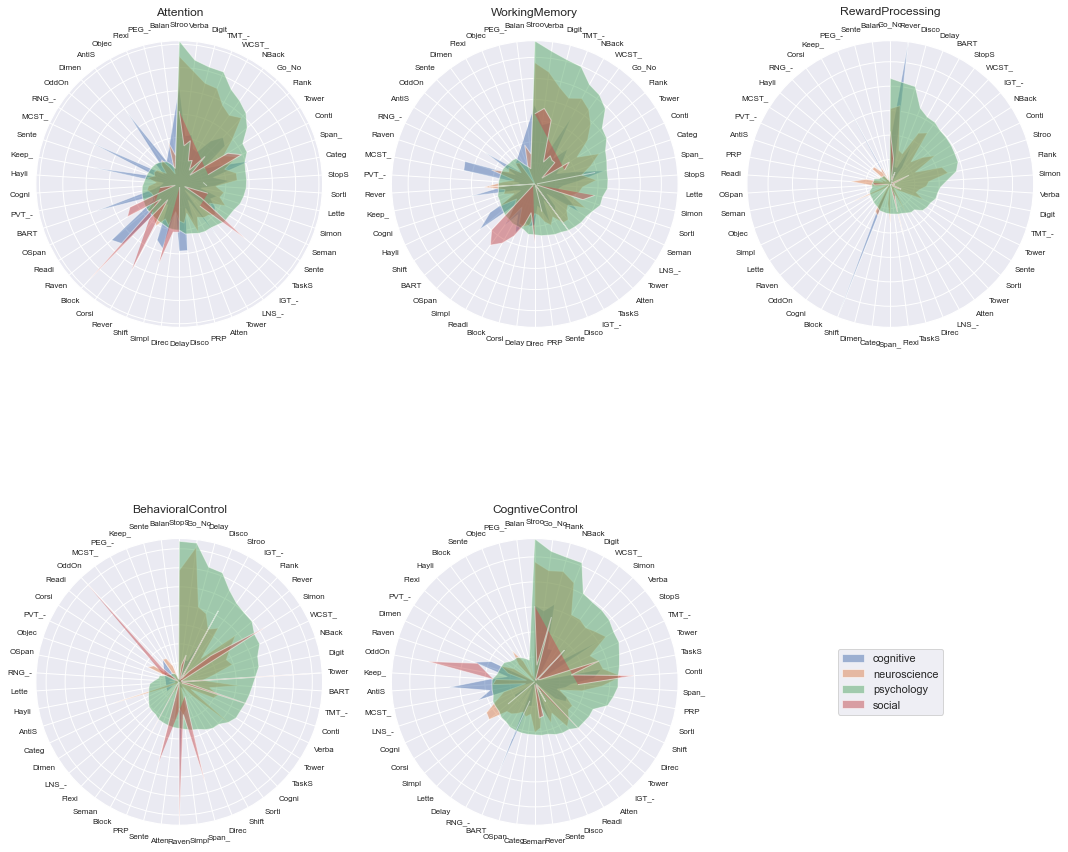

In [98]:
sim_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='cosine')

fig, axes = plt.subplots(2,3,figsize=(15,15), subplot_kw=dict(projection='polar'))

constructs = ['Attention', 'WorkingMemory', 'RewardProcessing', 'BehavioralControl', 'CogntiveControl']

for i,construct in enumerate(constructs):
  ax = axes.flatten()[i]
  data = sim_df.query('construct == @construct').T
  data.columns = data.columns.droplevel(1)
  data = data.sort_values(by='psychology', ascending=False).reset_index()
  rose_plot(data, ax=ax, alpha=0.5, fontsize=8)
  ax.set_title(construct)


# improve overall aesthetics
axes.flatten()[-1].set_axis_off()
handles, labels = axes.flatten()[0].get_legend_handles_labels()
plt.legend(handles, labels, loc='center')
fig.tight_layout()
plt.show()



In [99]:
# create task-signature for the most popular constructs

kl_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='kl')
sim_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='cosine')

task                                       AntiSaccadeTask  \
scientific_community construct                               
cognitive            Attention                    0.380682   
                     AttentionalControl           0.299911   
                     BehavioralControl            0.062850   
                     CentralExecutive             0.063078   
                     CognitiveFlexibility         0.336763   
...                                                    ...   
social               ShortTermMemory                   NaN   
                     Switching                         NaN   
                     VerbalWorkingMemory               NaN   
                     Volition                          NaN   
                     WorkingMemory                     NaN   

task                                       AttentionNetworkTest      BART  \
scientific_community construct                                              
cognitive            Attention                         0.176484  0.376140   
                     AttentionalControl                0.192415  0.217433   
                     BehavioralControl                 0.007949  0.118380   
                     CentralExecutive                  0.155443  0.115955   
                     CognitiveFlexibility              0.282870  0.102026   
...                                                         ...       ...   
social               ShortTermMemory                   0.001941  0.005062   
                     Switching                         0.002434  0.007535   
                     VerbalWorkingMemory               0.003948  0.005902   
                     Volition                          0.114290  0.005441   
                     WorkingMemory                     0.001283  0.009842   

task                                       BlockDesignSubTest  \
scientific_community construct                                  
cognitive            Attention                       0.353124   
                     AttentionalControl              0.176755   
                     BehavioralControl               0.074373   
                     CentralExecutive                0.092934   
                     CognitiveFlexibility            0.121168   
...                                                       ...   
social               ShortTermMemory                 0.101728   
                     Switching                       0.100214   
                     VerbalWorkingMemory             0.080651   
                     Volition                        0.139383   
                     WorkingMemory                   0.264109   

task                                       CategoryFluencyTask  \
scientific_community construct                                   
cognitive            Attention                        0.149117   
                     AttentionalControl               0.014181   
                     BehavioralControl                0.018185   
                     CentralExecutive                 0.158798   
                     CognitiveFlexibility             0.014781   
...                                                        ...   
social               ShortTermMemory                       NaN   
                     Switching                             NaN   
                     VerbalWorkingMemory                   NaN   
                     Volition                              NaN   
                     WorkingMemory                         NaN   

task                                       CognitiveFlexibilityTask  \
scientific_community construct                                        
cognitive            Attention                             0.079428   
                     AttentionalControl                    0.001076   
                     BehavioralControl                     0.001152   
                     CentralExecutive                      0.001434   
                     CognitiveFlexibility                  0

In [ ]:
plot_hypernomy('CogntiveControl', kl_df.applymap(lambda x: x if x < 100 else np.nan))

In [ ]:
# plot histograms of constructs across scientific communities

plot_hypernomy('Attention', sim_df)
plot_hypernomy('WorkingMemory', sim_df)
plot_hypernomy('RewardProcessing', sim_df)
plot_hypernomy('BehavioralControl', sim_df)
plot_hypernomy('CogntiveControl', sim_df)
plot_hypernomy('CogntiveControl', kl_df)

In [ ]:
plot_hypernomy('CogntiveControl', kl_df.applymap(lambda x: np.log(x)))